# 1. Introduction
This will be the longest EDA you've ever seen...

Let's load some libraries and the data.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline

DATASET_PATH = '/media/rs/0E06CD1706CD0127/Kapok/WSDM/'
train = pd.read_csv(DATASET_PATH+'train.csv')
test = pd.read_csv(DATASET_PATH+'test.csv')

# 2. Adding song year to our datasets

In [2]:
songs_extra = pd.read_csv(DATASET_PATH+'song_extra_info.csv')

def isrc_to_year(isrc):
    if type(isrc) == str:
        if int(isrc[5:7]) > 17:
            return 1900 + int(isrc[5:7])
        else:
            return 2000 + int(isrc[5:7])
    else:
        return np.nan
        
songs_extra['song_year'] = songs_extra['isrc'].apply(isrc_to_year)
print(songs_extra['isrc'][0:100])
print(songs_extra['isrc'][:-100])
songs_extra.drop(['isrc', 'name'], axis = 1, inplace = True)

train = train.merge(songs_extra, on = 'song_id', how = 'left')
test = test.merge(songs_extra, on = 'song_id', how = 'left')
# In the United States until late 2015 this was “US” or "QM" but after this date, it became “QZ” for new registrant code allocations

0     TWUM71200043
1     QMZSY1600015
2     TWA530887303
3     USSM11301446
4     TWA471306001
5     GBAYE1400079
6     HKUM70704066
7     USWD10423930
8     HKA610200010
9     TWI431000103
10    USWB11400510
11    GBHMU1400159
12    TWB439808011
13    TWF710800009
14    TWD970400025
15             NaN
16             NaN
17    TWA451294108
18    USAT21601931
19    GBAHT0108626
20    GBPS81528405
21    TWK971201102
22             NaN
23    TWA530887311
24    JPTK08680213
25    CAM460437524
26    TWL251507101
27             NaN
28    TWS171500002
29    TWA459801803
          ...     
70    USWD10423285
71             NaN
72    JPPO01019350
73    USUM70832594
74             NaN
75    TWC150102002
76             NaN
77    TWUM71400150
78    JPTK08880508
79    NLR881500081
80    TWA750300806
81    JPB601502828
82    CNA651500228
83    USSM11505897
84    GBCEL1600015
85    TWW131301103
86    JPVI01440060
87    TWA771101005
88    TWA459652601
89    TWA459964202
90    JPP751101085
91          

In [3]:
print(train.head())

                                           msno  \
0  FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=   
1  Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=   
2  Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=   
3  Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=   
4  FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=   

                                        song_id source_system_tab  \
0  BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=           explore   
1  bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=        my library   
2  JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=        my library   
3  2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=        my library   
4  3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=           explore   

    source_screen_name      source_type  target  song_year  
0              Explore  online-playlist       1     2016.0  
1  Local playlist more   local-playlist       1     1999.0  
2  Local playlist more   local-playlist       1     2006.0  
3  Local playlist more   local-pla

# 3. Let's count what fraction of songs was released in 2017
We will use rolling mean with a window of 50000 for this purpose.

In [4]:
train['2017_songs_frac'] = (train['song_year'] == 2017).rolling(window = 50000, center = True).mean()
test['2017_songs_frac'] = (test['song_year'] == 2017).rolling(window = 50000, center = True).mean()

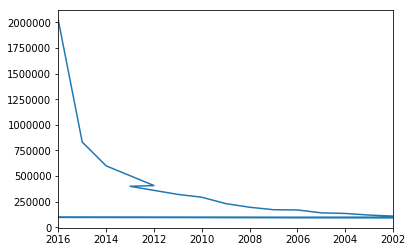

In [5]:
train[train['song_year']>2000]['song_year'].value_counts().plot()

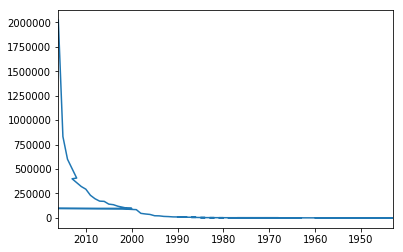

In [6]:
train['song_year'].value_counts().plot()

In [7]:
keep_indice = list()
#mean_percent = (train['song_year'] == 2017).rolling(window = 5000, center = True).mean()
for col in range(7277417, 7377417):#range(7176417, 7377417):
    cur_per = train['2017_songs_frac'][col]#mean_percent[col]
    keep_prob = (1. - 0.7*cur_per/(1.-cur_per))/1.7
    if train['song_year'][col] != 2017:
        if np.random.random_sample() < keep_prob:
            keep_indice.append(col)
    else:
        keep_indice.append(col)

print('{} are keeped.'.format(len(keep_indice)))

keep_train = train.iloc[keep_indice].copy(deep=True)#.reset_index(drop=True)
keep_train.index = pd.RangeIndex(len(keep_train.index))
#print(keep_train)
store = pd.HDFStore(DATASET_PATH+'validation_indice.csv')
store['keep_index'] = pd.DataFrame({'index': keep_indice})
store.close()

#keep_train['2017_songs_frac'] = (keep_train['song_year'] == 2017.0).rolling(window = 5000, center = True).mean()
keep_train['2017_songs_frac'] = train['2017_songs_frac'].iloc[keep_indice].copy(deep=True).reset_index(drop=True)

45809 are keeped.


# 4. Let's plot it against train and test index values

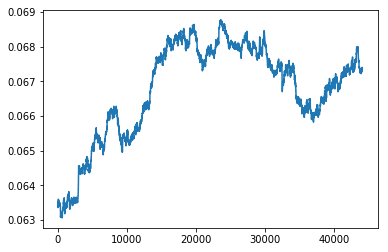

In [8]:
plt.figure()
plt.plot(keep_train.index.values, keep_train['2017_songs_frac'], '-');

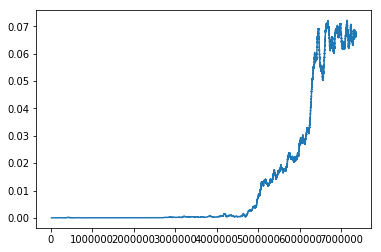

In [9]:
plt.figure()
plt.plot(train.index.values, train['2017_songs_frac'], '-');

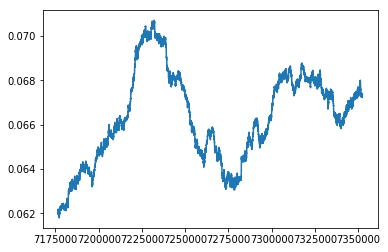

In [10]:
plt.figure()
plt.plot(train.index.values[7176417:7377417], train['2017_songs_frac'][7176417:7377417], '-');

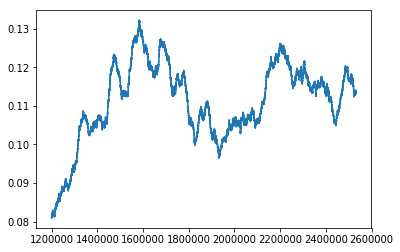

In [11]:
plt.plot(test.index.values[1200000:], test['2017_songs_frac'][1200000:], '-');

# 5. Yes! Data is chronologically ordered!
I think everyone should be aware of this, maybe even organizers should confirm this. It does help to establish a pretty good (as for the time series problem) validation set - you just leave last 2.5 mln (length of the test data) rows of the training data for the validation. It helped me to get 0.69 score without even taking a time series approach to this problem.